# 감성 분석 모델 학습 및 추론

### 1. 데이터 로드

In [56]:
import pandas as pd

In [57]:
data = pd.read_csv('/Users/sanbyeol/Desktop/SKN17/SKN17_mountainStar/nlp/05_text_classification/finance_data_sentimantal.csv')

### 2. 데이터 전처리

In [58]:
data.head()

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [59]:
#한글만 포함 
data = data.drop(columns='sentence')

In [60]:
# 결측치 처리
data.isna().sum()

labels          0
kor_sentence    0
dtype: int64

In [61]:
# 감정 인코딩 
data['labels'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [62]:
mapping = {'neutral':0, 'negative':1, 'positive':2}
data['labels'] = data['labels'].map(mapping)

In [ ]:
# 한글 토큰화 전처리 (특수문자 처리, 어간 추출, 불용어 처리) -> 함수
from konlpy.tag import Okt
import re

okt = Okt()

# 불용어 파일
ko_stopwords = pd.read_csv("ko_stopwords.txt", header=None, names=["word"])
ko_stopwords = ko_stopwords["word"].tolist()


def preprocess_korean(text):
    # 1) 특수문자 제거 
    text =  re.sub(r'[^가-힣\s]', ' ', text)
    
    # 2) 형태소 분석 + 어간 추출
    tokens = okt.morphs(text, stem=True)
    
    # 3) 불용어 제거
    tokens = [t for t in tokens if t not in ko_stopwords and len(t) > 1]
    
    return tokens

In [64]:
data['tokens'] = data['kor_sentence'].map(preprocess_korean)
data[:5]

,labels,kor_sentence,tokens
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...","[따르다, 회사, 회사, 성장하다, 모든, 생산, 러시아, 옮기다, 계획, 없다, 하다]"
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...,"[테크노, 폴리스, 컴퓨터, 기술, 통신, 분야, 하다, 회사, 유치하다, 위해, ..."
2,1,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ...","[국제, 산업, 회사, 엘코텍, 탈린, 공장, 수십, 명의, 직원, 해고, 하다, ..."
3,2,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...,"[새롭다, 생산, 공장, 인하다, 회사, 예상, 되다, 수요, 증가, 충족, 능력,..."
4,2,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4...","[회사, 업데이트, 되다, 전략, 따르다, 늘다, 범위, 장기, 매출, 성장, 목표..."


In [65]:
# 정수 인코딩 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch

NUM_WORDS = 10000   # 너무 작으면 OOV가 많아짐
OOV_TOKEN = "<OOV>"
MAX_LEN = 50

texts_for_tokenizer = [" ".join(toks) for toks in data['tokens']]

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(texts_for_tokenizer)

sequences = tokenizer.texts_to_sequences(texts_for_tokenizer)

In [66]:
# 패딩

padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')


In [67]:
# 원본 토큰 / 정수 인코딩 / 패딩 결과 비교

print("원문 토큰:", data['tokens'].iloc[i])
print("정수 인코딩:", sequences[i])
print("패딩 결과:")
print(padded[i])


원문 토큰: ['국제', '산업', '회사', '엘코텍', '탈린', '공장', '수십', '명의', '직원', '해고', '하다', '이전', '해고', '와는', '달리', '회사', '사무직', '직원', '줄이다', '일간', '포스', '메스', '보도', '하다']
정수 인코딩: [237, 63, 7, 323, 662, 37, 1712, 80, 51, 163, 2, 105, 163, 2595, 2055, 7, 2056, 51, 586, 1300, 1485, 3604, 286, 2]
패딩 결과:
[ 237   63    7  323  662   37 1712   80   51  163    2  105  163 2595
 2055    7 2056   51  586 1300 1485 3604  286    2    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [68]:
print("단어 사전 크기:", len(tokenizer.word_index))

단어 사전 크기: 6653


In [69]:
labels = data['labels'].values
print(labels)

[0 0 1 ... 1 1 1]


In [ ]:
# Torch 텐서
X = torch.tensor(padded, dtype=torch.long)
y = torch.tensor(labels, dtype=torch.long)   # 다중분류
print(X.shape, y.shape)

torch.Size([4846, 50]) torch.Size([4846])


In [71]:
VOCAB_SIZE = min(NUM_WORDS, len(tokenizer.word_index) + 1)
print("VOCAB_SIZE:", VOCAB_SIZE)

VOCAB_SIZE: 6654


### 3. 모델 정의 및 생성

In [72]:
# 데이터 셋 학습/평가 분리

from torch.utils.data import TensorDataset, random_split, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

dataset = TensorDataset(X, y)
train_size = int(len(dataset) * 0.8)
val_size   = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

In [ ]:
# 모델 정의

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, num_classes=3, pad_idx=0, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        emb = self.embedding(x)           
        _, (h, _) = self.lstm(emb)        
        h = self.dropout(h[-1])          
        return self.fc(h)               


In [74]:
# 모델 인스턴스 생성
VOCAB_SIZE = min(NUM_WORDS, len(tokenizer.word_index) + 1)  # Tokenizer 기반
EMBEDDING_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = 3   # 감성(중립, 부정, 긍정)

lstm_model = SentimentLSTM(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes =OUTPUT_DIM)

print(lstm_model)

SentimentLSTM(
  (embedding): Embedding(6654, 64, padding_idx=0)
  (lstm): LSTM(64, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


### 4. 모델 학습

[1/30] Train Loss: 0.9615, Train Acc: 0.5903 | Val Loss: 0.9109, Val Acc: 0.6052
[2/30] Train Loss: 0.9341, Train Acc: 0.5913 | Val Loss: 0.9084, Val Acc: 0.6052
[3/30] Train Loss: 0.9299, Train Acc: 0.5913 | Val Loss: 0.9096, Val Acc: 0.6052
[4/30] Train Loss: 0.9323, Train Acc: 0.5913 | Val Loss: 0.9097, Val Acc: 0.6052
[5/30] Train Loss: 0.9338, Train Acc: 0.5913 | Val Loss: 0.9085, Val Acc: 0.6052
[6/30] Train Loss: 0.9316, Train Acc: 0.5913 | Val Loss: 0.9099, Val Acc: 0.6052
[7/30] Train Loss: 0.9314, Train Acc: 0.5913 | Val Loss: 0.9092, Val Acc: 0.6052
⏹ 조기 종료 발동!


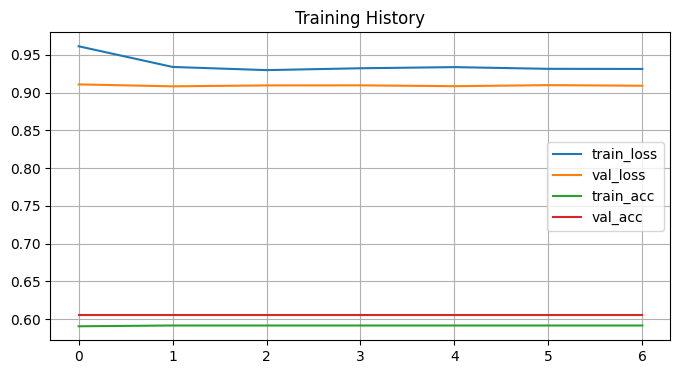

In [ ]:
#학습

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3)


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=5):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        # -
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)                  
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = outputs.argmax(dim=1)
            correct += (pred == targets).sum().item()
            total += targets.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total


        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_targets)
                val_loss += loss.item()

                val_pred = val_outputs.argmax(dim=1)
                val_correct += (val_pred == val_targets).sum().item()
                val_total += val_targets.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"[{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # ---- Early stopping ----
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            best_state = model.state_dict()
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("⏹ 조기 종료 발동!")
                model.load_state_dict(best_state)
                break

    # 시각화
    history = pd.DataFrame({
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs
    })
    history.plot(figsize=(8,4), grid=True, title="Training History")
    plt.show()

    return model

# 실행
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30, patience=5)

### 5. 추론

In [ ]:
id_to_label = {0:"중립😕", 1:"부정🥵", 2:"긍정😀"}

import numpy as np
import torch
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_sentiment(model, tokenizer, sentence, max_len=50, device="cpu"):
    model.eval()

    # 전처리
    tokens = preprocess_korean(sentence)
    txt = " ".join(tokens)
    seq = tokenizer.texts_to_sequences([txt])[0]  # 정수 리스트

    #확인
    print("입력 문장:", sentence)
    print("전처리 토큰:", tokens)
    print("정수 시퀀스:", seq[:20])

    if len(seq) == 0:
        oov_idx = tokenizer.word_index.get("<OOV>", 1)
        seq = [oov_idx]

  
    pad = pad_sequences([seq], maxlen=max_len, padding="post", truncating="post")


    x = torch.tensor(pad, dtype=torch.long).to(device)
    with torch.no_grad():
        logits = model(x)                 
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

    pred_idx = int(probs.argmax())
    label_map = {0: "neutral", 1: "negative", 2: "positive"}
    return label_map[pred_idx], float(probs[pred_idx]), probs

In [101]:
predict_sentiment(lstm_model, tokenizer, "회사가 인수합병을 하면서 주가가 올랐다")

입력 문장: 회사가 인수합병을 하면서 주가가 올랐다
전처리 토큰: ['회사', '인수합병', '하다', '주가']
정수 시퀀스: [7, 1, 2, 182]


('negative',
 0.3437672257423401,
 array([0.31676847, 0.34376723, 0.33946428], dtype=float32))

In [77]:
while True:
    input_sentence = input("감성 예측할 문장을 입력하세요! (X:종료)")

    if input_sentence.strip().upper() == 'X':
        break

    label, prob, probs = predict_sentiment(lstm_model, tokenizer, input_sentence, max_len=50)

    print(f"\n문장: {input_sentence}")
    print(f"예측 : {label} (확률={prob:.4f})")
    print(f"전체 확률 분포: 중립😕={probs[0]:.3f}, 부정🥵={probs[1]:.3f}, 긍정😀={probs[2]:.3f}\n")


문장: 새로운 생산공장으로 회사 수요가 증가를 총족시킬수있다
예측 : 부정🥵 (확률=0.3438)
전체 확률 분포: 중립😕=0.317, 부정🥵=0.344, 긍정😀=0.339


문장: 회사가 인수합병을 하면서 주가가 올랐다
예측 : 부정🥵 (확률=0.3438)
전체 확률 분포: 중립😕=0.317, 부정🥵=0.344, 긍정😀=0.339


문장: 회사가 부도났다
예측 : 부정🥵 (확률=0.3438)
전체 확률 분포: 중립😕=0.317, 부정🥵=0.344, 긍정😀=0.339



_____________

labels
0    2879
2    1363
1     604
Name: count, dtype: int64
labels
0    0.594098
2    0.281263
1    0.124639
Name: proportion, dtype: float64


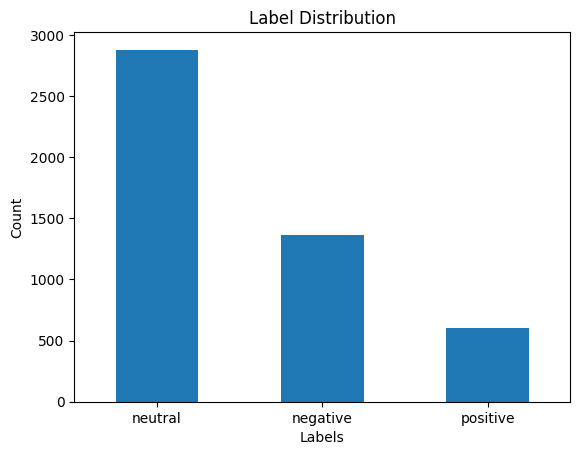

In [102]:
import matplotlib.pyplot as plt

# 라벨 분포 확인
print(data['labels'].value_counts())

# 비율까지 확인
print(data['labels'].value_counts(normalize=True))

# 시각화 (막대 그래프)
data['labels'].value_counts().plot(kind='bar')
plt.xticks([0,1,2], ['neutral', 'negative', 'positive'], rotation=0)
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

______________

# 라벨 불균형 보정 => class weigh 